In [7]:
import numpy as np
import pandas as pd
from typing import Union, List, Tuple
import matplotlib.pyplot as plt
import matplotlib as mpl
from DataTransformation import LowPassFilter
from scipy.signal import argrelextrema
from sklearn.metrics import mean_absolute_error

mpl.style.use("fivethirtyeight")
mpl.rcParams["figure.figsize"] = (15, 8)
mpl.rcParams["figure.dpi"] = 50
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25

pd.options.mode.chained_assignment = None

In [3]:
# --------------------------------------------------------------
# Load data before the feature engineering step
# --------------------------------------------------------------

df = pd.read_pickle("../data/interim/01_data_resampled.pkl")
df = df[df["label"] != "rest"]
df.head(3)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,28
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,28
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,28


In [4]:
# Calculating acc_r and gyr_r again
acc_r = df["acc_x"] ** 2 + df["acc_y"] ** 2 + df["acc_z"] ** 2
gyr_r = df["gyr_x"] ** 2 + df["gyr_y"] ** 2 + df["gyr_z"] ** 2

df["acc_r"] = np.sqrt(acc_r)
df["gyr_r"] = np.sqrt(gyr_r)

df.head(3)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,28,0.979669,3.225625
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,28,0.973752,2.887270
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,28,0.973795,2.936720


In [5]:
# --------------------------------------------------------------
# Split data
# --------------------------------------------------------------

# Creating 5 Dataframes for each exercise
bench_df = df[df["label"] == "bench"]
squat_df = df[df["label"] == "squat"]
row_df = df[df["label"] == "row"]
ohp_df = df[df["label"] == "ohp"]
dead_df = df[df["label"] == "dead"]

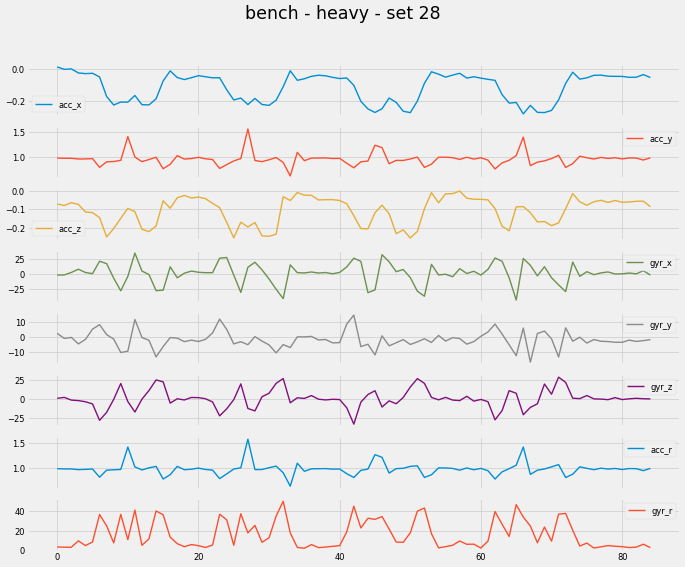

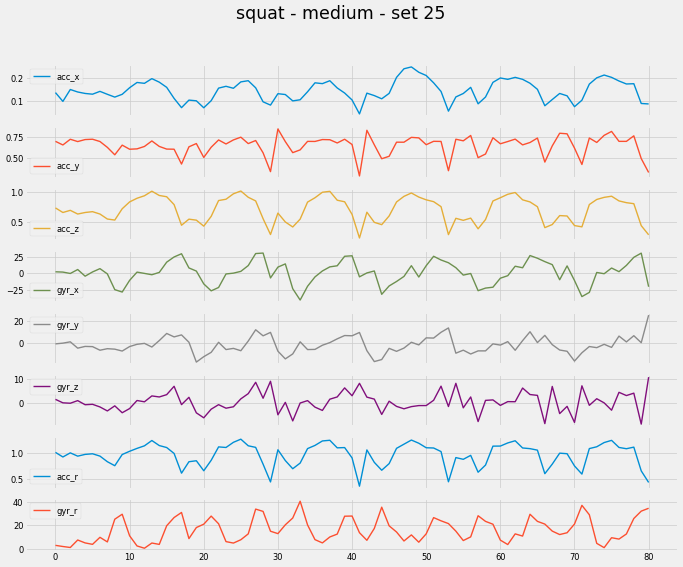

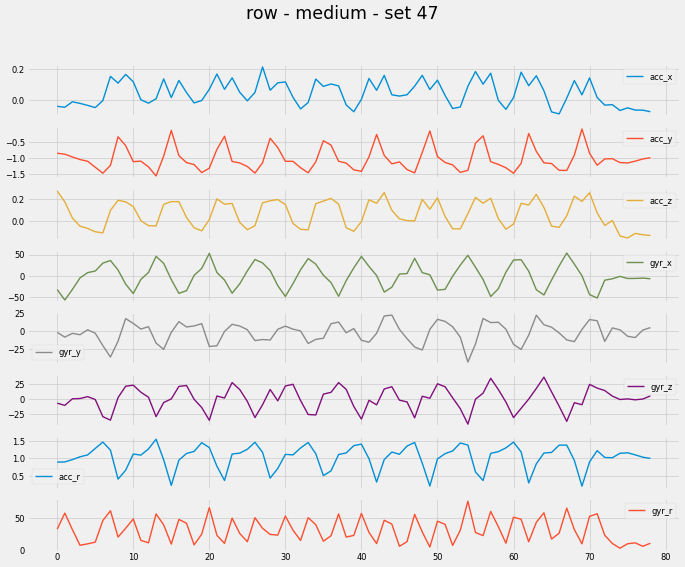

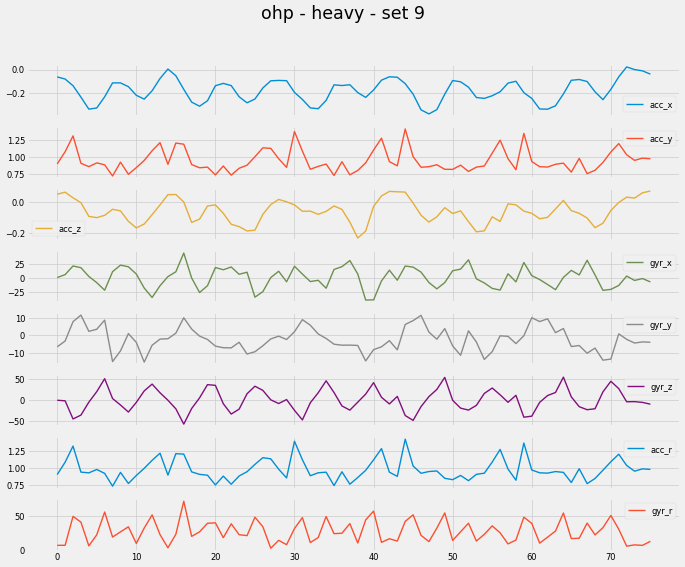

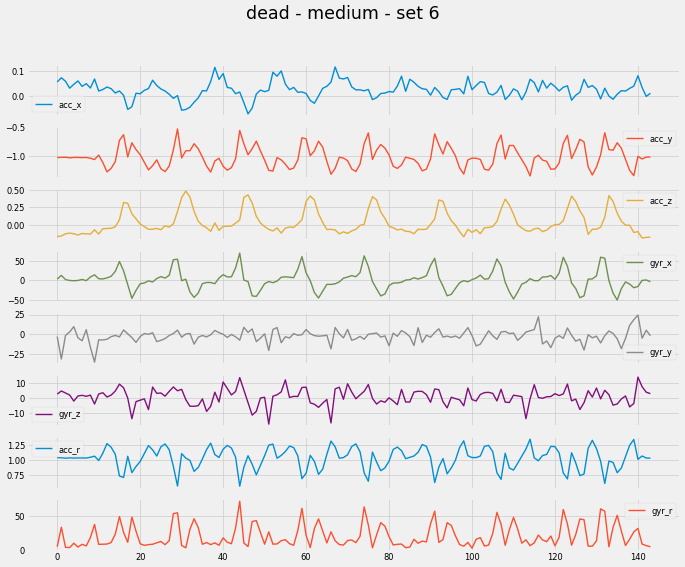

In [36]:
# --------------------------------------------------------------
# Visualize data to identify patterns
# --------------------------------------------------------------

# Looping through each label (exercises) and ploting for each sensor (acc and gyro)
list_df = [bench_df, squat_df, row_df, ohp_df, dead_df]

for plot_df in list_df:
    cat = plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["category"].unique()[0]
    label = plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["label"].unique()[0]
    set = plot_df["set"].unique()[0]
    plot_df[plot_df["set"] == plot_df["set"].unique()[0]].drop(
        "set", axis=1
    ).reset_index(drop=True).plot(
        subplots=True, figsize=(15, 12), title=f"{label} - {cat} - set {set}"
    )

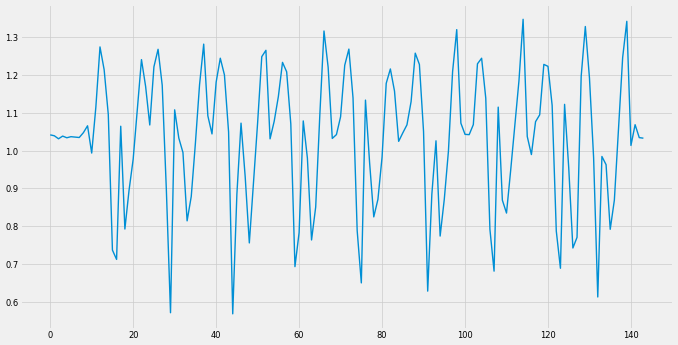

In [15]:
# --------------------------------------------------------------
# Apply LowPassFilter
# --------------------------------------------------------------

# Get just one set for each exercise
bench_set = bench_df[bench_df["set"] == bench_df["set"].unique()[0]]
squat_set = squat_df[squat_df["set"] == squat_df["set"].unique()[0]]
row_set = row_df[row_df["set"] == row_df["set"].unique()[0]]
ohp_set = ohp_df[ohp_df["set"] == ohp_df["set"].unique()[0]]
dead_set = dead_df[dead_df["set"] == dead_df["set"].unique()[0]]

# Before the LowPassFilter is applied, the data is plotted
# to verify that the filter is working correctly
dead_set["acc_r"].reset_index(drop=True).plot(label="raw");

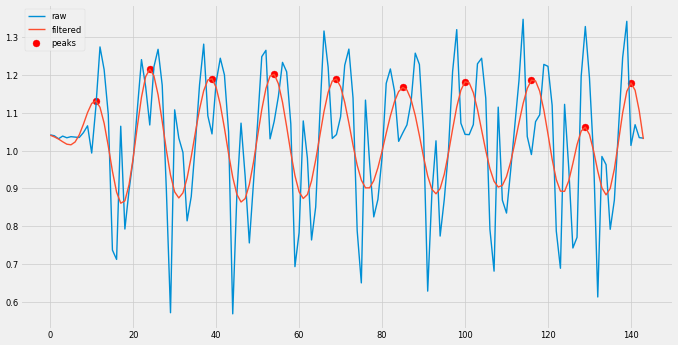

In [24]:
# Before the LowPassFilter is applied, the data is plotted
# to see if the filter is working correctly
dead_set["acc_r"].reset_index(drop=True).plot(label="raw")

# Configure LowPassFilter
fs = 1000 / 200
LowPass = LowPassFilter()
cutoff = 0.5
columns = "acc_r"
order = 10

# After applying the filter, the data is plotted again
temp_data = LowPass.low_pass_filter(
    dead_set.reset_index(drop=True),
    col=columns,
    sampling_frequency=fs,
    cutoff_frequency=cutoff,
    order=order,
)
temp_data[columns + "_lowpass"].plot(label="filtered")

# Find the local maxima (peaks) in the filtered data.
idx_max = argrelextrema(
    data=temp_data[columns + "_lowpass"].values, comparator=np.greater
)
peaks = temp_data[columns + "_lowpass"].iloc[idx_max]

# Peaks
plt.scatter(x=idx_max, y=peaks, c="red", s=100, label="peaks")

plt.legend()
plt.show()

In [29]:
# --------------------------------------------------------------
# Create function to count repetitions
# --------------------------------------------------------------

def count_reps(
    dataset: pd.DataFrame,
    cutoff: Union[float, int],
    order: 10,
    columns: List[str],
    plot: bool = True,
) -> Tuple[pd.Series, pd.Index, int]:
    """
    Count the number of peaks in the low-pass filtered data for specified columns.

    Parameters:
        dataset (pd.DataFrame): The input dataset containing the time-series data.
        cutoff (Union[float, int]): The cutoff frequency for the low-pass filter.
        order (int): The order of the low-pass filter.
        columns (List[str]): A list of column names in the dataset to process.
        plot (bool, optional): If True, plot the raw and filtered data with identified peaks.
                                Default is True.

    Returns:
        Tuple[pd.Series, pd.Index, int]: A tuple containing:
            - peaks (pd.Series): A pandas Series containing the peak values for each column.
            - idx_max (pd.Index): The indices of the identified peaks in the filtered data.
            - num_peaks (int): The total number of peaks found in the data.

    Notes:
        The function applies a low-pass filter to the dataset using the specified cutoff frequency
        and order. It then identifies local maxima (peaks) in the filtered data and returns
        their values along with their indices. If `plot` is True, the function also generates
        a plot with the raw and filtered data, highlighting the identified peaks.
    """
    # `LowPass.low_pass_filter()` is a function that returns the low-pass filtered data.
    data = LowPass.low_pass_filter(
        dataset.reset_index(drop=True),
        col=columns,
        sampling_frequency=fs,  # Note: `fs` should be defined somewhere in the code.
        cutoff_frequency=cutoff,
        order=order,
    )[columns + "_lowpass"]

    # Find the local maxima (peaks) in the data.
    idx_max = argrelextrema(data=data.values, comparator=np.greater)
    peaks = data.iloc[idx_max]

    if plot:
        fig, ax = plt.subplots()
        # Ploting raw
        dataset[columns].reset_index(drop=True).plot(label="raw")
        # After applying the filter
        data.plot(label="filtered")
        # Plot the peaks
        plt.scatter(x=idx_max, y=peaks, c="red", s=100, label=f"peaks ({len(peaks)})")
        label = dataset["label"].iloc[0].title()
        category = dataset["category"].iloc[0].title()
        ax.set_ylabel(f"{columns}_lowpass")
        plt.title(f"{label} - {category}: {len(peaks)} reps")

    return peaks, idx_max, len(peaks)

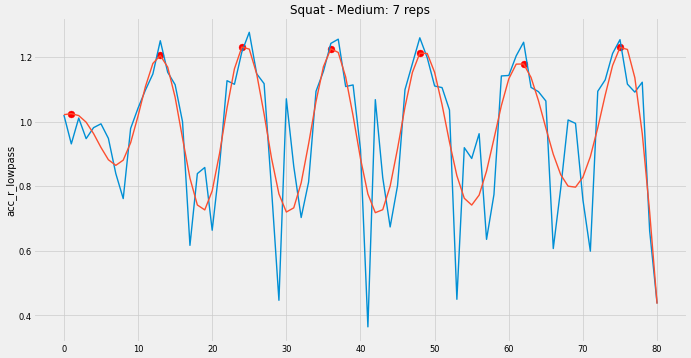

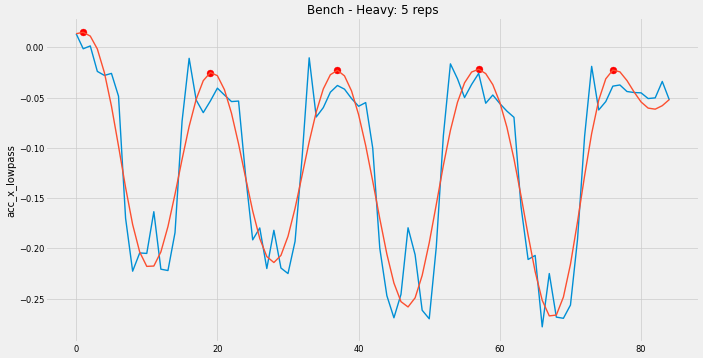

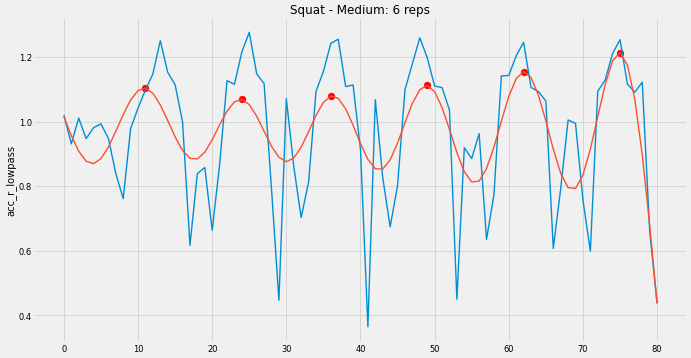

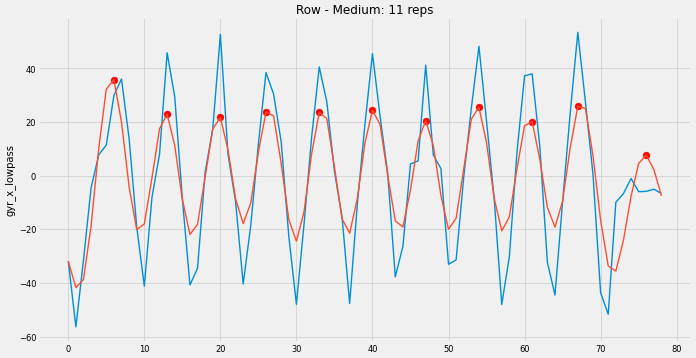

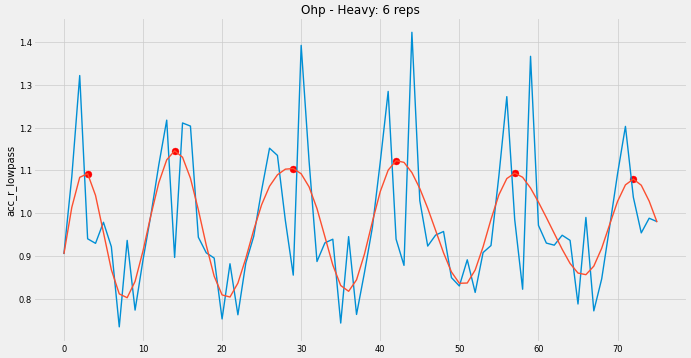

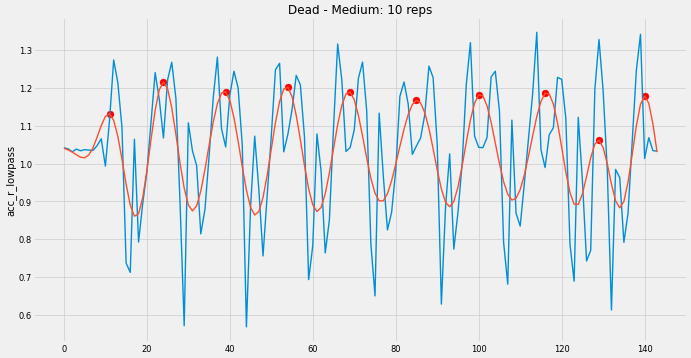

In [30]:
cutoff = 0.6
columns = "acc_r"
order = 10
dataset = squat_set

peaks, idx_max, num_peaks = count_reps(dataset, cutoff, order, columns)


peaks, idx_max, num_peaks = count_reps(bench_set, 0.5, 10, "acc_x")  # bench press
peaks, idx_max, num_peaks = count_reps(squat_set, 0.4, 10, "acc_r")  # squat
peaks, idx_max, num_peaks = count_reps(row_set, 0.75, 10, "gyr_x")  # row
peaks, idx_max, num_peaks = count_reps(ohp_set, 0.65, 10, "acc_r")  # ohp
peaks, idx_max, num_peaks = count_reps(dead_set, 0.5, 10, "acc_r")  # dead

In [33]:
# --------------------------------------------------------------
# Create benchmark dataframe using MAE
# --------------------------------------------------------------

# Creating a column to apply the number of reps for each label (medium or heavy)
df["reps"] = df["category"].apply(lambda x: 5 if x == "heavy" else 10)

rep_df = df.groupby(["label", "category", "set"])["reps"].max().reset_index()
rep_df["reps_pred"] = 0

display(rep_df.head())
display(rep_df.tail())

,label,category,set,reps,reps_pred
0,bench,heavy,1,5,0
1,bench,heavy,2,5,0
2,bench,heavy,3,5,0
3,bench,heavy,4,5,0
4,bench,heavy,28,5,0


,label,category,set,reps,reps_pred
73,squat,medium,26,10,0
74,squat,medium,27,10,0
75,squat,medium,36,10,0
76,squat,medium,58,10,0
77,squat,medium,59,10,0


In [34]:
# Looping over the df to apply the number of reps for each label (medium or heavy)
for s in df["set"].unique():
    subset = df[df["set"] == s]

    if subset["label"].iloc[0] == "bench":
        cutoff = 0.6
        columns = "acc_x"

    elif subset["label"].iloc[0] == "squat":
        cutoff = 0.4
        columns = "acc_r"

    elif subset["label"].iloc[0] == "row":
        cutoff = 0.65
        columns = "gyr_x"

    elif subset["label"].iloc[0] == "ohp":
        cutoff = 0.5
        columns = "acc_r"

    elif subset["label"].iloc[0] == "dead":
        cutoff = 0.4
        columns = "acc_r"

    peaks, idx_max, num_peaks = count_reps(subset, cutoff, 10, columns, plot=False)

    rep_df.loc[rep_df["set"] == s, "reps_pred"] = num_peaks

display(rep_df.head())
display(rep_df.tail())

,label,category,set,reps,reps_pred
0,bench,heavy,1,5,5
1,bench,heavy,2,5,4
2,bench,heavy,3,5,4
3,bench,heavy,4,5,5
4,bench,heavy,28,5,5


,label,category,set,reps,reps_pred
73,squat,medium,26,10,10
74,squat,medium,27,10,10
75,squat,medium,36,10,7
76,squat,medium,58,10,11
77,squat,medium,59,10,9


#### Results (MAE)

- The Mean Absolute Error (MAE) is a statistical error measure used to quantify errors between paired observations that express the same phenomenon.
- In the context of Y versus X, Y represents the predicted value, while X represents the actual value.
- The MAE is calculated as the sum of absolute errors divided by the sample size. The absolute error is the difference between the predicted and true values, and the sample size is the number of observations in the dataset.
- MAE is an arithmetic average of absolute errors, which means it gives equal weight to all errors, regardless of their direction (positive or negative).
- MAE is a scale-dependent measure of accuracy, which means it uses the same scale as the data being measured. Therefore, it cannot be used to compare predicted values that use different scales.


<img src="../img/MAE.jpg">


MAE: 0.81


<Axes: xlabel='label,category'>

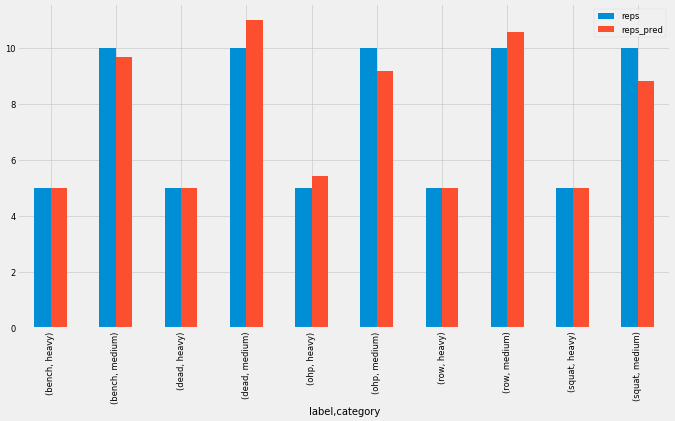

In [35]:
# --------------------------------------------------------------
# Evaluate the results
# --------------------------------------------------------------

error = mean_absolute_error(y_true=rep_df["reps"], y_pred=rep_df["reps_pred"]).round(2)
print(f"MAE: {error}")

# Plot the diference
rep_df.groupby(["label", "category"])[["reps", "reps_pred"]].mean().plot.bar()